In [1]:
#!pip install celery

In [2]:
#!sudo rabbitmqctl add_user myguest myguestpwd
#!sudo rabbitmqctl set_permissions -p / myguest "." "." ".*"

In [3]:
#!sudo rabbitmqctl list_users

In [4]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import json

from sklearn.datasets import make_blobs
from copy import deepcopy

from celery import group
from kmeans_workers import kmeans_tasks, dist, NumpyEncoder


In [5]:
n_samples=1600
n_clusters=3
n_features =2
n_workers = 4

In [6]:
# Creating a n_features=2 Dim dataset with centers=3 clusters
Xs, Ys = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters)

In [7]:
mydata= [{"points": x, "label": np.random.randint(n_clusters)} for x in Xs]

In [8]:
print(len(mydata))
print(mydata[15]['points'],mydata[15]['label'])

1600
[ 5.36945758 -5.02030359] 2


In [9]:
# Split the sequence in a number of chunks and process those independently.

l = n_samples // n_workers
Xsubseqs = [mydata[i * l:(i + 1) * l] for i in range(n_workers - 1)]
Xsubseqs.append(mydata[(n_workers - 1) * l:])


In [10]:
len(Xsubseqs[0])

400

In [11]:
np.matrix(np.diag(np.max(Xs,0)))

matrix([[ 6.51727172,  0.        ],
        [ 0.        , 10.40129423]])

In [12]:
C=np.matrix(np.random.rand(n_clusters,n_features))*np.matrix(np.diag(np.max(Xs,0)))
print("Initial Centroids")
print(C)


Initial Centroids
[[2.92108508 9.77437752]
 [4.24416183 2.41066769]
 [0.16650016 6.84372301]]


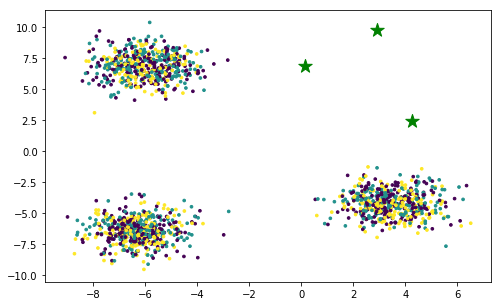

In [13]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 5)
fig = plt.figure()

# Plotting along with the Centroids
#plt.scatter([actdata.points[0] for actdata in mydata], [actdata.points[1] for actdata in mydata])
plt.scatter([actdata['points'][0] for actdata in mydata], [actdata['points'][1] for actdata in mydata],c=[actdata['label'] for actdata in mydata], s=7)

plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')


In [14]:
len([actdata['label'] for actdata in mydata])

1600

In [15]:
# To store the value of centroids when it updates
C_old = np.zeros(C.shape)
# Error func. - Distance between new centroids and old centroids
error = dist(C, C_old, None)
print(error)

13.219670546246705


In [16]:
print(C)
print(C.shape)

[[2.92108508 9.77437752]
 [4.24416183 2.41066769]
 [0.16650016 6.84372301]]
(3, 2)


In [17]:
partials_Estep=[json.loads(kmeans_tasks(task='estep', json_dump = json.dumps({'C': C, 'X': seq}, cls=NumpyEncoder)))['X'] for seq in Xsubseqs]

*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***


In [18]:
# the updated labels are here:
len(partials_Estep[0])

400

In [19]:
len(partials_Estep)

4

In [20]:
partials_Mstep=[json.loads(kmeans_tasks(task='mstep', json_dump = json.dumps({'X': seq, 'n_clusters': n_clusters, 'n_features':n_features}, cls=NumpyEncoder)))['C'] for seq in partials_Estep]

*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***


/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [21]:
partials_Mstep

[[[0.0, 0.0],
  [-1.3669059254404996, -5.395516869165953],
  [-6.041866659485815, 6.842392975133473]],
 [[0.0, 0.0],
  [-1.3430132989697066, -5.364864167091182],
  [-5.912378849030822, 6.789258437364037]],
 [[0.0, 0.0],
  [-1.5980550069828026, -5.465951944235304],
  [-5.991932885521052, 6.755869100332022]],
 [[0.0, 0.0],
  [-1.1281569058067746, -5.127958242968172],
  [-6.030282690252071, 6.862398843737767]]]

In [22]:
C=np.sum(partials_Mstep,0)/n_workers
print(C)

[[ 0.          0.        ]
 [-1.35903278 -5.33857281]
 [-5.99411527  6.81247984]]


In [23]:
# Storing the old centroid values
C_old = deepcopy(C)
 

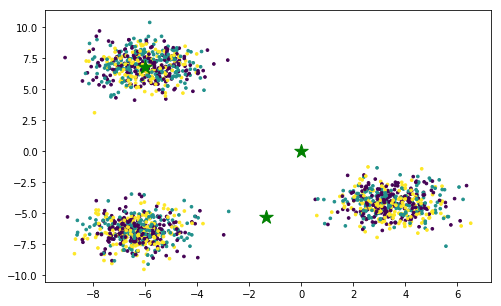

In [24]:
# Plotting along with the Centroids

#plt.scatter([actdata.points[0] for actdata in mydata], [actdata.points[1] for actdata in mydata],c='#050505', s=7)
plt.scatter([actdata['points'][0] for actdata in mydata], [actdata['points'][1] for actdata in mydata],c=[actdata['label'] for actdata in mydata], s=7)
plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')


### Everything together

(3, 2)
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
0.0
400
400
400
400


/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


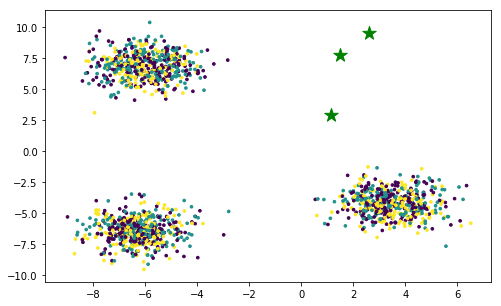

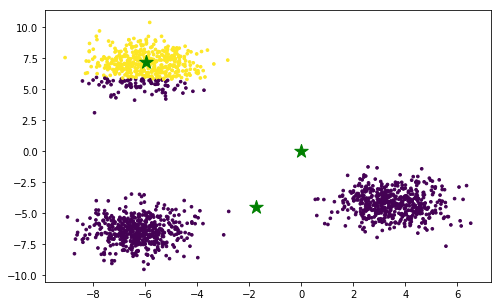

(3, 2)
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
0.0
400
400
400
400


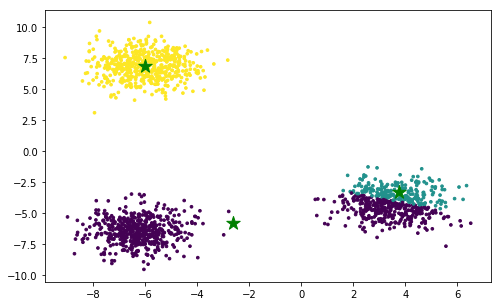

(3, 2)
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
0.0
400
400
400
400


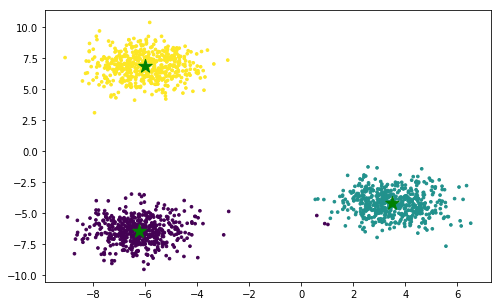

(3, 2)
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
0.0
400
400
400
400


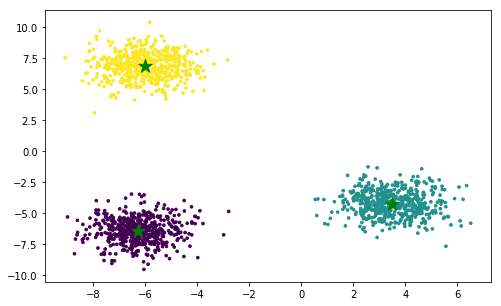

(3, 2)
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
0.0
400
400
400
400


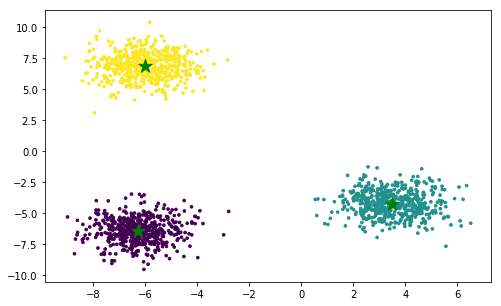

In [25]:
# Split the sequence in a number of chunks and process those independently.
n_workers = 4
n_iter =5

l = n_samples // n_workers
Xsubseqs = [mydata[i * l:(i + 1) * l] for i in range(n_workers - 1)]
Xsubseqs.append(mydata[(n_workers - 1) * l:])
C=np.matrix(np.random.rand(n_clusters,n_features))*np.matrix(np.diag(np.max(Xs,0)))

#plt.scatter([actdata.points[0] for actdata in mydata], [actdata.points[1] for actdata in mydata],c='#050505', s=7)
plt.scatter([actdata['points'][0] for actdata in mydata], [actdata['points'][1] for actdata in mydata],c=[actdata['label'] for actdata in mydata], s=7)
plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')

for iter in range(0, n_iter):    

    print(C.shape)
    
    #class assignnment
    partials_Estep=[json.loads(kmeans_tasks(task='estep', json_dump = json.dumps({'C': C, 'X': seq}, cls=NumpyEncoder)))['X'] for seq in Xsubseqs]
    
    #centroid update assignnment
    partials_Mstep=[json.loads(kmeans_tasks(task='mstep', json_dump = json.dumps({'X': seq, 'n_clusters': n_clusters, 'n_features':n_features}, cls=NumpyEncoder)))['C'] for seq in partials_Estep]
    
    C=np.sum(partials_Mstep,0)/n_workers
    C_old = deepcopy(C)
    error = dist(C, C_old, None)
    print(error)

    Xsubseqs=deepcopy(partials_Estep)
    
    mydata_updated=[]
    for seq in partials_Estep:
        mydata_updated.extend(seq)
        print(len(seq))
    len(mydata_updated)

    plt.rcParams['figure.figsize'] = (8, 5)
    fig = plt.figure()
    plt.scatter([actdata['points'][0] for actdata in mydata_updated], [actdata['points'][1] for actdata in mydata_updated],c=[actdata['label'] for actdata in mydata_updated], s=7)

    plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')
    plt.show()
    
    #time.sleep(2)


### Distributed Kmeans

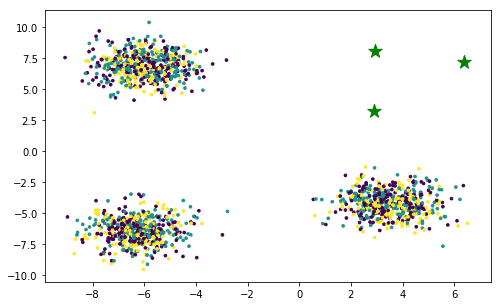

In [26]:
# Split the sequence in a number of chunks and process those independently.
n_workers = 4
n_iter =5

l = n_samples // n_workers
Xsubseqs = [mydata[i * l:(i + 1) * l] for i in range(n_workers - 1)]
Xsubseqs.append(mydata[(n_workers - 1) * l:])
C=np.matrix(np.random.rand(n_clusters,n_features))*np.matrix(np.diag(np.max(Xs,0)))

#plt.scatter([actdata.points[0] for actdata in mydata], [actdata.points[1] for actdata in mydata],c='#050505', s=7)
plt.scatter([actdata['points'][0] for actdata in mydata], [actdata['points'][1] for actdata in mydata],c=[actdata['label'] for actdata in mydata], s=7)
plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')


In [27]:
#class assignnment
#lazy_partials_Estep = group(kmeans_tasks.s(task='estep', json_dump = json.dumps({'C': C, 'X': seq}, cls=NumpyEncoder)) for seq in Xsubseqs)() 
# call remote workers to run the sort task 
#tmp_partials_Estep = lazy_partials_Estep.get() # will wait for the tasks to return


(3, 2)
0.0
400
400
400
400


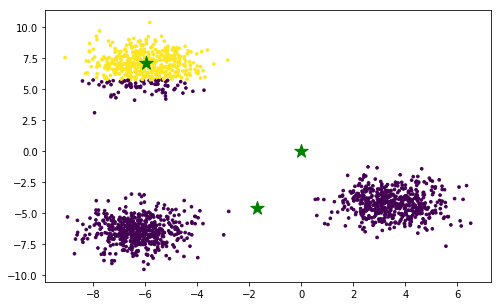

(3, 2)
0.0
400
400
400
400


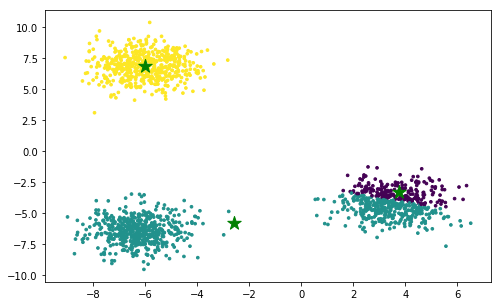

(3, 2)
0.0
400
400
400
400


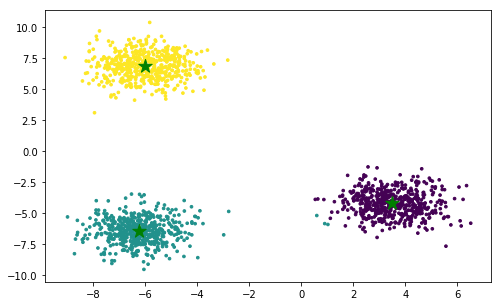

(3, 2)
0.0
400
400
400
400


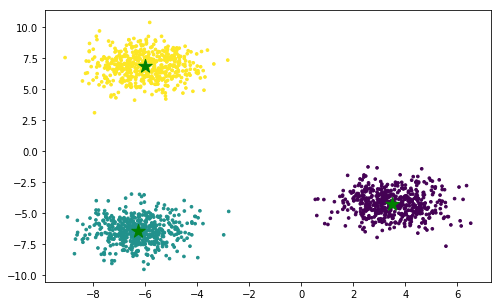

(3, 2)
0.0
400
400
400
400


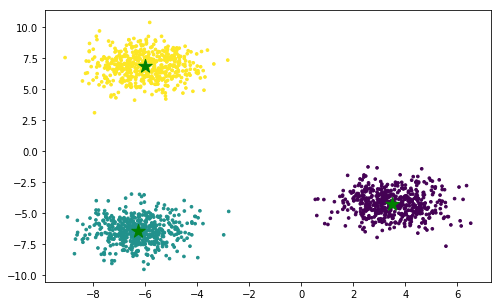

In [28]:
for iter in range(0, n_iter):    

    print(C.shape)
    
    #class assignnment
    lazy_partials_Estep = group(kmeans_tasks.s(task='estep', json_dump = json.dumps({'C': C, 'X': seq}, cls=NumpyEncoder)) 
                                               for seq in Xsubseqs)() 
    # call remote workers to run the sort task 
    tmp_partials_Estep = lazy_partials_Estep.get() # will wait for the tasks to return
    partials_Estep=[json.loads(seq)['X'] for seq in tmp_partials_Estep]

    #partials_Estep=[kmeans_tasks(task='estep', json_dump = json.dumps({'C': C, 'X': seq}, cls=NumpyEncoder)) for seq in Xsubseqs]
    
    #centroid update assignnment
    lazy_partials_Mstep = group(kmeans_tasks.s(task='mstep', json_dump = 
                                               json.dumps({'X': seq, 'n_clusters': n_clusters, 'n_features':n_features}, 
                                                          cls=NumpyEncoder)) for seq in partials_Estep)()
    tmp_partials_Mstep = lazy_partials_Mstep.get()  
    partials_Mstep=[json.loads(seq)['C'] for seq in tmp_partials_Mstep]
    #partials_Mstep=[kmeans_tasks(task='mstep', json_dump = json.dumps({'X': seq, 'n_clusters': n_clusters, 'n_features':n_features}, cls=NumpyEncoder)) for seq in partials_Estep]
    
    C=np.sum(partials_Mstep,0)/n_workers
    C_old = deepcopy(C)
    error = dist(C, C_old, None)
    print(error)

    Xsubseqs=deepcopy(partials_Estep)
    
    # plotting
    mydata_updated=[]
    for seq in partials_Estep:
        mydata_updated.extend(seq)
        print(len(seq))
    len(mydata_updated)

    plt.rcParams['figure.figsize'] = (8, 5)
    fig = plt.figure()
    plt.scatter([actdata['points'][0] for actdata in mydata_updated], [actdata['points'][1] for actdata in mydata_updated],c=[actdata['label'] for actdata in mydata_updated], s=7)

    plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')
    plt.show()
    
    #time.sleep(2)

    
    

